In [26]:
import os
import numpy as np
import pandas as pd
import umap
import time
from Bio import SeqIO
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Patch
os.chdir('/biodata/franco/zsuzsa_lab/jupyter')
import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'mono', fontsize = 10, colors = 'banskt', dpi = 100)
from tqdm import tqdm

import collections
import json 

monomer_dict = collections.defaultdict(dict)

with open("monomer_all_OK_ss_dict.json") as f:
    monomer_dict = json.load(f)

with open("../monomer_OK_fullset_annotations.fasta") as instrm:
    for record in SeqIO.parse(instrm, "fasta"):
            if record.id in monomer_dict:
                monomer_dict[record.id]['disorder'] = str(record.seq)



In [27]:
monomer_matches_data = dict()
missing_count = 0
missing_files = []
for monomer_id in monomer_dict:
    match_file = f"/biodata/franco/zsuzsa_lab/loss_T5_monomer2/{monomer_id}.json"
    if os.path.exists(match_file):
        with open(match_file) as f:
            monomer_matches_data[monomer_id] = json.load(f)[monomer_id]['aamask_1']
    else:
        missing_files.append((monomer_id, match_file))
        missing_count += 1
print(f"Missing {missing_count} files")
print(f"Loaded {len(monomer_matches_data.keys())} files")

Missing 0 files
Loaded 2984 files


In [28]:
monomer_dict[monomer_id]

{'seq': 'ENLKLGFLVKQPEEPWFQTEWKFADKAGKDLGFEVIKIAVPDGEKTLNAIDSLAASGAKGFVICTPDPKLGSAIVAKARGYDMKVIAVDDQFVNAKGKPMDTVPLVMLAATKIGERQGQELYKEMQKRGWDVKESAVMAITANELDTARRRTTGSMDALKAAGFPEKQIYQVPTKSNDIPGAFDAANSMLVQHPEVKHWLIVGMNDSTVLGGVRATEGQGFKAADIIGIGINGVDAVSELSKAQATGFYGSLLPSPDVHGYKSSEMLYNWVAKDVEPPKFTEVTDVVLITRDNFKEELEKKGLGGK',
 'ss': '---BBBBBBB-----HHHHHHHHHHHHHHH---BBBBBB--HHHHHHHHHHHHHHHH-BBBBBB-----HHHHHHHHHHHH--BBBBBB--------------BBBBBHHHHHHHHHHHHHHHHHHHHH------BBBBBB----HHHHHHHHHHHHHHHH--------BBB----HHHHHHHHHHHHHHHH------BBBBBB-HHHHHHHHHHHHH------BBBBBBBBHHHHHHHHH-----BBBBBBB---HHHHHHHHHHHHHHHHH-------BBB---BBBBB-HHHHHHHHH-----',
 'disorder': 'D-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------'}

In [29]:
aa_vocabulary = "ACDEFGHIKLMNPQRSTVWY"
aa_vocab_list = list(aa_vocabulary)

# Contains mismatches for each sequence, in the format of a dict with relative positiones of each mismatch
# 0-based indexing, mismatch at the masked position +1 position forwards, -1 backwards
# With this, then I can then stratify by protein length and ss the mismatch counts and distances to mask!
mismatch_count_dict = dict()
# it only depends on where the mask token was put! not where the mismatch happens
mismatch_count_dict_maskH = dict()  
mismatch_count_dict_maskB = dict()
mismatch_count_dict_maskU = dict()
mismatch_count_dict_maskD = dict()


# in this case, depends where the mismatch happens, not where the mask token was put
mismatch_count_dict_mismdiso = dict()  
mismatch_count_dict_mismordr = dict()

wrong_aa = list()
not_valid_aa = list()
total_residues   = 0
total_residues_H = 0
total_residues_B = 0
total_residues_U = 0
total_residues_D = 0

total_residues_H_by_length = collections.defaultdict(int)
total_residues_B_by_length = collections.defaultdict(int)
total_residues_U_by_length = collections.defaultdict(int)
total_residues_D_by_length = collections.defaultdict(int)

each_bin_totals_match = collections.defaultdict(int)

for monomer_id in tqdm(monomer_matches_data.keys()):
    seq = monomer_dict[monomer_id]['seq']
    ss_seq = monomer_dict[monomer_id]['ss']
    diso_seq = monomer_dict[monomer_id]['disorder']
    matches = monomer_matches_data[monomer_id]['match']

    H_ix = [True if e == "H" else False for e in ss_seq]
    B_ix = [True if e == "B" else False for e in ss_seq]
    U_ix = [True if e == "-" else False for e in ss_seq]
    D_ix = [True if e == "D" else False for e in diso_seq]
    
    total_residues   += len(seq)
    total_residues_H += len([e for e in H_ix if e == True])
    total_residues_B += len([e for e in B_ix if e == True])
    total_residues_U += len([e for e in U_ix if e == True])
    total_residues_D += len([e for e in D_ix if e == True])

    total_residues_H_by_length[len(seq)] += len([e for e in H_ix if e == True])
    total_residues_B_by_length[len(seq)] += len([e for e in B_ix if e == True])
    total_residues_U_by_length[len(seq)] += len([e for e in U_ix if e == True])
    total_residues_D_by_length[len(seq)] += len([e for e in D_ix if e == True])

    mismatch_count_dict[monomer_id] = collections.defaultdict(int)
    mismatch_count_dict_maskH[monomer_id] = collections.defaultdict(int)
    mismatch_count_dict_maskB[monomer_id] = collections.defaultdict(int)
    mismatch_count_dict_maskU[monomer_id] = collections.defaultdict(int)
    mismatch_count_dict_maskD[monomer_id] = collections.defaultdict(int)

    # in this case, depends where the mismatch happens, not where the mask token was put
    mismatch_count_dict_mismdiso[monomer_id] = collections.defaultdict(int)
    mismatch_count_dict_mismordr[monomer_id] = collections.defaultdict(int)
    assert len(matches) == len(seq)
    context_size = 20
    for current_pos, match in enumerate(matches):

        #check if match is bool or list
        if type(match) == bool:
            ## this entire sequence was predicted accurately
            from_context = max(0, current_pos-context_size)
            to_context = min(len(seq), current_pos+context_size+1)
            # dc_context = np.sum(diso_ix[from_context:to_context])/(to_context-from_context)
            # # quantize disorder content every 0.1 (10 bins)
            # quant_dc = int(dc_context * 10)/10
            # each_bin_totals_match[quant_dc] += 1
        else:
            onsite_mismatch_found = False
            for m in match:
                mismatch_pos, aa_predicted, aa_orig = m
                ## is the original aa a valid aminoacid?
                if (aa_orig not in aa_vocab_list) or (seq[mismatch_pos] not in aa_vocab_list):
                    not_valid_aa.append((monomer_id, mismatch_pos, aa_orig, seq[mismatch_pos]))
                    continue
                
                ## this is in case the embedded aa is different than the original sequence aa (just in case)
                if aa_orig != seq[mismatch_pos]:
                    wrong_aa.append((monomer_id, mismatch_pos, aa_orig, seq[mismatch_pos]))
                    continue
                
                if mismatch_pos == current_pos:
                    ## on-site mismatch
                    onsite_mismatch_found = True
                relative_pos = mismatch_pos - current_pos
                mismatch_count_dict[monomer_id][relative_pos] += 1
                
                from_context = max(0, current_pos-context_size)
                to_context = min(len(seq), current_pos+context_size+1)
                # dc_context = np.sum(diso_ix[from_context:to_context])/(to_context-from_context)
                # # quantize disorder content every 0.1 (10 bins)
                # quant_dc = int(dc_context * 10)/10
                if H_ix[current_pos]:
                    mismatch_count_dict_maskH[monomer_id][relative_pos] += 1
                if B_ix[current_pos]:
                    mismatch_count_dict_maskB[monomer_id][relative_pos] += 1
                if U_ix[current_pos]:
                    mismatch_count_dict_maskU[monomer_id][relative_pos] += 1
                if D_ix[current_pos]:
                    mismatch_count_dict_maskD[monomer_id][relative_pos] += 1


                # if diso_ix[current_pos]:
                #     mismatch_count_dict_maskdiso[monomer_id][relative_pos] += 1
                    # if quant_dc not in mismatch_count_dict_maskdiso_context_dc[monomer_id][relative_pos]:
                    #     mismatch_count_dict_maskdiso_context_dc[monomer_id][relative_pos][quant_dc] = 0
                    # mismatch_count_dict_maskdiso_context_dc[monomer_id][relative_pos][quant_dc] += 1
                # else:
                #     mismatch_count_dict_maskordr[monomer_id][relative_pos] += 1
                    # if quant_dc not in mismatch_count_dict_maskordr_context_dc[monomer_id][relative_pos]:
                    #     mismatch_count_dict_maskordr_context_dc[monomer_id][relative_pos][quant_dc] = 0
                    # mismatch_count_dict_maskordr_context_dc[monomer_id][relative_pos][quant_dc] += 1
            if not onsite_mismatch_found:
                ## add the on-site match to the pool of matches -> not done, but not counting matches?
                from_context = max(0, current_pos-context_size)
                to_context = min(len(seq), current_pos+context_size+1)
                # dc_context = np.sum(diso_ix[from_context:to_context])/(to_context-from_context)
                # quant_dc = int(dc_context * 10)/10
                # each_bin_totals_match[quant_dc] += 1

100%|██████████| 2984/2984 [00:01<00:00, 1696.86it/s]


In [30]:
## If the mask is put in a disordered region, what happens?
## compare mismatch counts wrt protein length

print(f"Total residues: {total_residues}")

print(f"Total B residues: {total_residues_B} ({total_residues_B/total_residues})")
print(f"Total H residues: {total_residues_H} ({total_residues_H/total_residues})")
print(f"Total U residues: {total_residues_U} ({total_residues_U/total_residues})")
print(f"Total D residues: {total_residues_D} ({total_residues_D/total_residues})")


def get_fractions(prot_dict, mismatch_count_dict, total_residues_type, label):
    fraction_mm_at0 = list()
    mm_at0 = 0
    for prot_id in mismatch_count_dict.keys():
        seq_len = len(prot_dict[prot_id]['seq'])
        fraction_mm = mismatch_count_dict[prot_id][0]/seq_len
        mm_at0 += mismatch_count_dict[prot_id][0]
        fraction_mm_at0.append(fraction_mm)

    fraction_mm_at0 = np.array(fraction_mm_at0)
    print(f"Fraction of total {label} residues that mismatch: {mm_at0/total_residues_type:.2f} ({mm_at0} of {total_residues_type})")
    return mm_at0/total_residues_type

Bfraction = get_fractions(monomer_dict, mismatch_count_dict_maskB, total_residues_B, "B")
Hfraction = get_fractions(monomer_dict, mismatch_count_dict_maskH, total_residues_H, "H")
Ufraction = get_fractions(monomer_dict, mismatch_count_dict_maskU, total_residues_U, "U")
Dfraction = get_fractions(monomer_dict, mismatch_count_dict_maskD, total_residues_D, "D")

# print(f"Avg mismatch @ 0 in order relative to prot length {order_fraction_mm_at0.mean():.2f} ({order_fraction_mm_at0.std():.2f} std)")
# print(f"Avg mismatch @ 0 in disorder relative to prot length {disorder_fraction_mm_at0.mean():.2f} ({disorder_fraction_mm_at0.std():.2f} std)")

# mpl_stylesheet.banskt_presentation(fontfamily = 'mono', fontsize = 14, colors = 'banskt', dpi = 100)

# fig = plt.figure(figsize=(6,6))
# ax1 = fig.add_subplot(111)
# b = ax1.bar(x = np.arange(2), height = [order_mm_at0/total_residues_order, 0]) #, tick_label=["order", "disorder"])
# b = ax1.bar(x = np.arange(2), height = [0, disorder_mm_at0/total_residues_disorder], tick_label=["order", "disorder"])

# for bar in ax1.patches:
#     if bar.get_height() > 0:
#         ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height()+0.02,
#                  format(bar.get_height(), '.2f'), 
#                  ha='center', va='center')
# ax1.set_ylim(0,0.75)
# ax1.set_title("Fraction of total masked\n sites that match - T5", ha='center')
# plt.show()

Total residues: 614467
Total B residues: 138782 (0.22585753181212334)
Total H residues: 242319 (0.394356409701416)
Total U residues: 233366 (0.37978605848646063)
Total D residues: 37762 (0.061454886918255985)
Fraction of total B residues that mismatch: 0.41 (57356 of 138782)
Fraction of total H residues that mismatch: 0.44 (106361 of 242319)
Fraction of total U residues that mismatch: 0.48 (112530 of 233366)
Fraction of total D residues that mismatch: 0.63 (23925 of 37762)


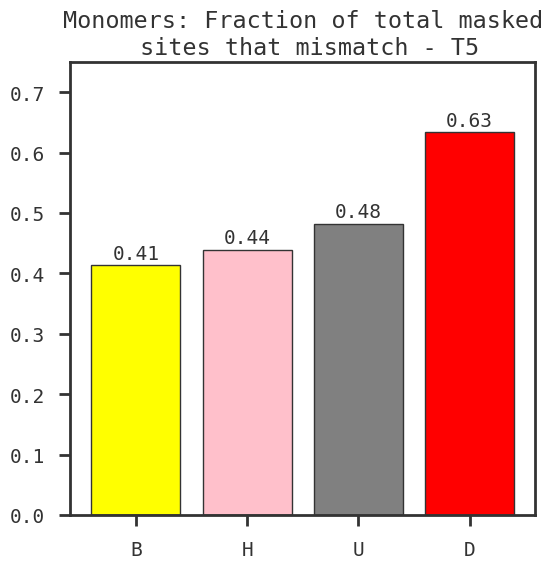

In [31]:
mpl_stylesheet.banskt_presentation(fontfamily = 'mono', fontsize = 14, colors = 'banskt', dpi = 100)

fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
b = ax1.bar(x = np.arange(4), height = [Bfraction, 0, 0, 0], color="yellow")
b = ax1.bar(x = np.arange(4), height = [0, Hfraction, 0, 0], color="pink")
b = ax1.bar(x = np.arange(4), height = [0, 0, Ufraction, 0], color="gray")
b = ax1.bar(x = np.arange(4), height = [0, 0, 0, Dfraction], tick_label=["B", "H", "U", "D"], color="red")

for bar in ax1.patches:
    if bar.get_height() > 0:
        ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height()+0.02,
                 format(bar.get_height(), '.2f'), 
                 ha='center', va='center')
ax1.set_ylim(0,0.75)
ax1.set_title("Monomers: Fraction of total masked\n sites that mismatch - T5", ha='center')
plt.show()

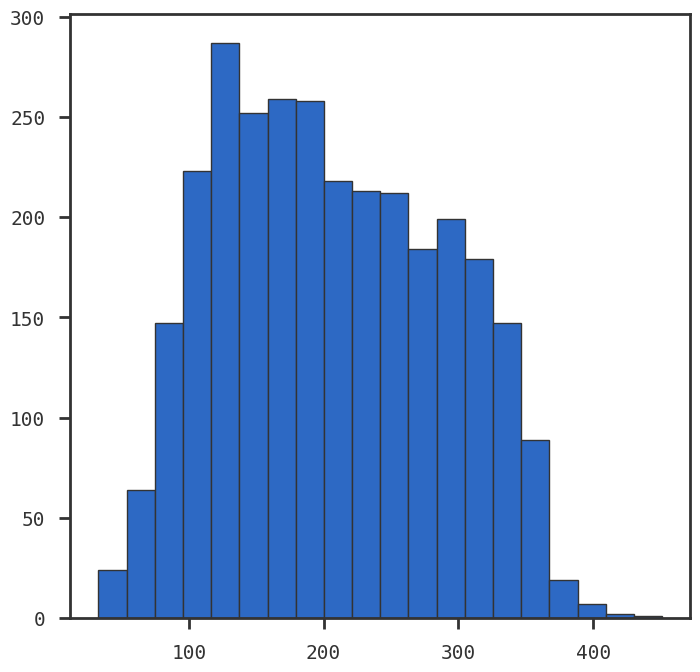

In [32]:
monomer_lengths = []
for pdbid in monomer_dict:
    monomer_lengths.append(len(monomer_dict[pdbid]['seq']))

plt.hist(monomer_lengths, bins=20)
plt.show()

In [33]:
len(monomer_lengths)

2984

0 100
Fraction of total B residues that mismatch: 0.41 (2176 of 5263)
Fraction of total H residues that mismatch: 0.43 (3452 of 8063)
Fraction of total U residues that mismatch: 0.47 (4088 of 8703)
Fraction of total D residues that mismatch: 0.60 (654 of 1089)
100 200
Fraction of total B residues that mismatch: 0.44 (20575 of 47042)
Fraction of total H residues that mismatch: 0.45 (31430 of 69478)
Fraction of total U residues that mismatch: 0.50 (34483 of 69472)
Fraction of total D residues that mismatch: 0.64 (7211 of 11259)
200 300
Fraction of total B residues that mismatch: 0.42 (21900 of 52130)
Fraction of total H residues that mismatch: 0.44 (43334 of 97876)
Fraction of total U residues that mismatch: 0.49 (45261 of 92190)
Fraction of total D residues that mismatch: 0.64 (9423 of 14735)
300 400
Fraction of total B residues that mismatch: 0.37 (12605 of 34072)
Fraction of total H residues that mismatch: 0.42 (27834 of 66339)
Fraction of total U residues that mismatch: 0.45 (28218 o

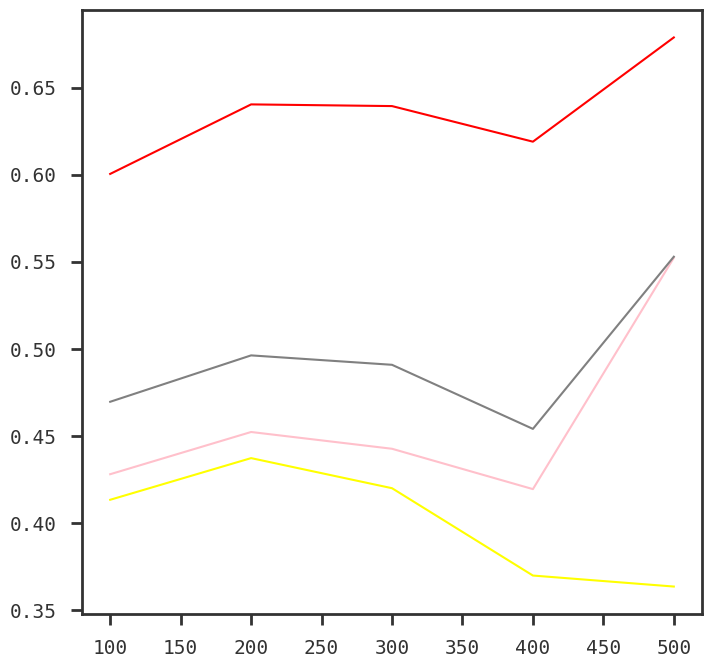

In [43]:

def get_fractions_by_len(prot_dict, minlen, maxlen, mismatch_count_dict, total_residues_type_by_length, label):
    fraction_mm_at0 = list()
    mm_at0 = 0
    total_residues_type = 0
    for seqlens in total_residues_type_by_length:
        if (seqlens > minlen) and (seqlens <= maxlen):
            total_residues_type += total_residues_type_by_length[seqlens]
    for prot_id in mismatch_count_dict.keys():
        seq_len = len(prot_dict[prot_id]['seq'])
        if (seq_len > minlen) and (seq_len <= maxlen):
            fraction_mm = mismatch_count_dict[prot_id][0]/seq_len
            mm_at0 += mismatch_count_dict[prot_id][0]
            fraction_mm_at0.append(fraction_mm)

    fraction_mm_at0 = np.array(fraction_mm_at0)
    print(f"Fraction of total {label} residues that mismatch: {mm_at0/total_residues_type:.2f} ({mm_at0} of {total_residues_type})")
    return mm_at0/total_residues_type


fig = plt.figure(figsize=(8,8))
ax  = fig.add_subplot(111)
bins = [(0,100), (100,200), (200,300), (300, 400), (400, 500)]
Bvalues = []
Hvalues = []
Uvalues = []
Dvalues = []
xvalues = []
for bin in bins:
    lower = bin[0]
    upper = bin[1]
    print(lower, upper)
    Bfraction = get_fractions_by_len(monomer_dict,lower, upper, mismatch_count_dict_maskB, total_residues_B_by_length, "B")
    Hfraction = get_fractions_by_len(monomer_dict,lower, upper, mismatch_count_dict_maskH, total_residues_H_by_length, "H")
    Ufraction = get_fractions_by_len(monomer_dict,lower, upper, mismatch_count_dict_maskU, total_residues_U_by_length, "U")
    Dfraction = get_fractions_by_len(monomer_dict,lower, upper, mismatch_count_dict_maskD, total_residues_D_by_length, "D")

    Bvalues.append(Bfraction)
    Hvalues.append(Hfraction)
    Uvalues.append(Ufraction)
    Dvalues.append(Dfraction)
    xvalues.append(upper)

ax.plot(xvalues, Bvalues, color="yellow", label="B")
ax.plot(xvalues, Hvalues, color="pink", label="H")
ax.plot(xvalues, Uvalues, color="gray", label="U")
ax.plot(xvalues, Dvalues, color="red", label="D")

plt.show()